# Intraday Mean Reversion: Buy-on-Gap Model

## The rules for the strategy are

### 1. Select all stocks near the market open whose returns from their previous day’s lows to today’s opens are lower than one standard deviation. The standard deviation is computed using the daily close-to-close returns of the last 90 days. These are the stocks that “gapped down.”

### 2. Narrow down this list of stocks by requiring their open prices to be higher than the 20-day moving average of the closing prices.

### 3. Buy the 10 stocks within this list that have the lowest returns from their previous day’s lows. If the list has fewer than 10 stocks, then buy the entire list.

### 4. Liquidate all positions at the market close.

###  The stock universe we used to backtest are the:
### 1. Hang Seng index
### 2. S&P 500 index

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from math import sqrt
from tqdm import tqdm
from datetime import datetime

pd.set_option('display.max_rows', 1000)

In [2]:
# Stocks in the Hang Seng index
HSI_stocks_list=["0001.HK", "0002.HK", "0003.HK", "0005.HK", "0006.HK", "0011.HK", "0012.HK", "0016.HK", "0017.HK", "0027.HK", "0066.HK", "0101.HK", "0175.HK", "0241.HK", "0267.HK", "0288.HK", "0291.HK", "0316.HK", "0322.HK", "0386.HK", "0388.HK", "0669.HK", "0688.HK", "0700.HK", "0762.HK", "0823.HK", "0836.HK", "0857.HK", "0868.HK", "0881.HK", "0883.HK", "0939.HK", "0941.HK", "0960.HK", "0968.HK", "0981.HK", "0992.HK", "1038.HK", "1044.HK", "1088.HK", "1093.HK", "1099.HK", "1109.HK", "1113.HK", "1177.HK", "1209.HK", "1211.HK", "1299.HK", "1378.HK", "1398.HK", "1810.HK", "1876.HK", "1928.HK", "1929.HK", "1997.HK", "2015.HK", "2020.HK", "2269.HK", "2313.HK", "2318.HK", "2319.HK", "2331.HK", "2359.HK", "2382.HK", "2388.HK", "2628.HK", "2688.HK", "2899.HK", "3690.HK", "3692.HK", "3968.HK", "3988.HK", "6098.HK", "6618.HK", "6690.HK", "6862.HK", "9618.HK", "9633.HK", "9888.HK", "9961.HK", "9988.HK", "9999.HK"
]
len(HSI_stocks_list)

82

In [3]:
# Stocks in the S&P500 
SPX_stocks_list=["MMM", "AOS", "ABT", "ABBV", "ACN", "ADBE", "AMD", "AES", "AFL", "A", "APD", "ABNB", "AKAM", "ALB", "ARE", "ALGN", "ALLE", "LNT", "ALL", "GOOGL", "GOOG", "MO", "AMZN", "AMCR", "AEE", "AAL", "AEP", "AXP", "AIG", "AMT", "AWK", "AMP", "AME", "AMGN", "APH", "ADI", "ANSS", "AON", "APA", "AAPL", "AMAT", "APTV", "ACGL", "ADM", "ANET", "AJG", "AIZ", "T", "ATO", "ADSK", "ADP", "AZO", "AVB", "AVY", "AXON", "BKR", "BALL", "BAC", "BK", "BBWI", "BAX", "BDX", "BRK.B", "BBY", "BIO", "TECH", "BIIB", "BLK", "BX", "BA", "BKNG", "BWA", "BXP", "BSX", "BMY", "AVGO", "BR", "BRO", "BF.B", "BLDR", "BG", "CDNS", "CZR", "CPT", "CPB", "COF", "CAH", "KMX", "CCL", "CARR", "CTLT", "CAT", "CBOE", "CBRE", "CDW", "CE", "COR", "CNC", "CNP", "CF", "CHRW", "CRL", "SCHW", "CHTR", "CVX", "CMG", "CB", "CHD", "CI", "CINF", "CTAS", "CSCO", "C", "CFG", "CLX", "CME", "CMS", "KO", "CTSH", "CL", "CMCSA", "CMA", "CAG", "COP", "ED", "STZ", "CEG", "COO", "CPRT", "GLW", "CTVA", "CSGP", "COST", "CTRA", "CCI", "CSX", "CMI", "CVS", "DHR", "DRI", "DVA", "DAY", "DE", "DAL", "XRAY", "DVN", "DXCM", "FANG", "DLR", "DFS", "DG", "DLTR", "D", "DPZ", "DOV", "DOW", "DHI", "DTE", "DUK", "DD", "EMN", "ETN", "EBAY", "ECL", "EIX", "EW", "EA", "ELV", "LLY", "EMR", "ENPH", "ETR", "EOG", "EPAM", "EQT", "EFX", "EQIX", "EQR", "ESS", "EL", "ETSY", "EG", "EVRG", "ES", "EXC", "EXPE", "EXPD", "EXR", "XOM", "FFIV", "FDS", "FICO", "FAST", "FRT", "FDX", "FIS", "FITB", "FSLR", "FE", "FI", "FLT", "FMC", "F", "FTNT", "FTV", "FOXA", "FOX", "BEN", "FCX", "GRMN", "IT", "GEHC", "GEN", "GNRC", "GD", "GE", "GIS", "GM", "GPC", "GILD", "GPN", "GL", "GS", "HAL", "HIG", "HAS", "HCA", "DOC", "HSIC", "HSY", "HES", "HPE", "HLT", "HOLX", "HD", "HON", "HRL", "HST", "HWM", "HPQ", "HUBB", "HUM", "HBAN", "HII", "IBM", "IEX", "IDXX", "ITW", "ILMN", "INCY", "IR", "PODD", "INTC", "ICE", "IFF", "IP", "IPG", "INTU", "ISRG", "IVZ", "INVH", "IQV", "IRM", "JBHT", "JBL", "JKHY", "J", "JNJ", "JCI", "JPM", "JNPR", "K", "KVUE", "KDP", "KEY", "KEYS", "KMB", "KIM", "KMI", "KLAC", "KHC", "KR", "LHX", "LH", "LRCX", "LW", "LVS", "LDOS", "LEN", "LIN", "LYV", "LKQ", "LMT", "L", "LOW", "LULU", "LYB", "MTB", "MRO", "MPC", "MKTX", "MAR", "MMC", "MLM", "MAS", "MA", "MTCH", "MKC", "MCD", "MCK", "MDT", "MRK", "META", "MET", "MTD", "MGM", "MCHP", "MU", "MSFT", "MAA", "MRNA", "MHK", "MOH", "TAP", "MDLZ", "MPWR", "MNST", "MCO", "MS", "MOS", "MSI", "MSCI", "NDAQ", "NTAP", "NFLX", "NEM", "NWSA", "NWS", "NEE", "NKE", "NI", "NDSN", "NSC", "NTRS", "NOC", "NCLH", "NRG", "NUE", "NVDA", "NVR", "NXPI", "ORLY", "OXY", "ODFL", "OMC", "ON", "OKE", "ORCL", "OTIS", "PCAR", "PKG", "PANW", "PARA", "PH", "PAYX", "PAYC", "PYPL", "PNR", "PEP", "PFE", "PCG", "PM", "PSX", "PNW", "PXD", "PNC", "POOL", "PPG", "PPL", "PFG", "PG", "PGR", "PLD", "PRU", "PEG", "PTC", "PSA", "PHM", "QRVO", "PWR", "QCOM", "DGX", "RL", "RJF", "RTX", "O", "REG", "REGN", "RF", "RSG", "RMD", "RVTY", "RHI", "ROK", "ROL", "ROP", "ROST", "RCL", "SPGI", "CRM", "SBAC", "SLB", "STX", "SRE", "NOW", "SHW", "SPG", "SWKS", "SJM", "SNA", "SO", "LUV", "SWK", "SBUX", "STT", "STLD", "STE", "SYK", "SYF", "SNPS", "SYY", "TMUS", "TROW", "TTWO", "TPR", "TRGP", "TGT", "TEL", "TDY", "TFX", "TER", "TSLA", "TXN", "TXT", "TMO", "TJX", "TSCO", "TT", "TDG", "TRV", "TRMB", "TFC", "TYL", "TSN", "USB", "UBER", "UDR", "ULTA", "UNP", "UAL", "UPS", "URI", "UNH", "UHS", "VLO", "VTR", "VLTO", "VRSN", "VRSK", "VZ", "VRTX", "VFC", "VTRS", "VICI", "V", "VMC", "WRB", "WAB", "WBA", "WMT", "DIS", "WBD", "WM", "WAT", "WEC", "WFC", "WELL", "WST", "WDC", "WRK", "WY", "WHR", "WMB", "WTW", "GWW", "WYNN", "XEL", "XYL", "YUM", "ZBRA", "ZBH", "ZION", "ZTS"
]
len(SPX_stocks_list)

503

## For 82 stocks in the Hang Seng index:

In [4]:
select_df=pd.DataFrame()

for stock in tqdm(HSI_stocks_list):
    
    try:
        
        # Get data from yahoo finance
        df=yf.download(stock, start="2020-01-01", end="2024-01-01")
        
        # State the stock symbol
        df["Stock"]=stock
        
        # Calculate Standard deviation by using the daily close-to-close returns of the last 90 days
        df["Std"]=df["Close"].rolling(90).std()
        
        # Create a new column for copying the previous day's low
        df["Previous_Low"]=df["Low"].shift(1)
        
        # Condition 1: (Previous day's Low - Today's open) < 1 Standard deviation
        df["Condition_1"]= (df["Previous_Low"]-df["Open"]) < df["Std"]
        
        # Find 20-day_moving_average by using closing prices
        df["20-day_moving_average"]=df["Close"].rolling(20).mean()
        # Condition 2: Open Prices > 20-day_moving_average
        df["Condition_2"]= (df["Open"]>df["20-day_moving_average"])
        
        # Filter out the data which fulfil both condition 1 and condition 2
        df["Filter"]=df["Condition_1"] & df["Condition_2"]

        # Calculate return
        df1=df[df["Filter"]==True].copy()
        # Set stop loss of 3%
        df1["Return"]=(df["Close"]-df["Open"])/df["Open"]
        df1["Return"]=df1["Return"].apply(lambda x: max(x, -0.03))

        # Store the filter data in select_df
        select_df=pd.concat([select_df, df1])
        select_df=select_df.sort_index(ascending=True)
        
    except:
        
        pass
    

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [5]:
final_df=pd.DataFrame()

# For each unique data in select_df, we will only buy the 10 stocks that have the 
# lowest return from their previous day's lows.
for date in tqdm(np.unique(select_df.index)):
    try:
        # Select all the data within one specific date
        Stocks_10=select_df.loc[date]
        
        # Sort by their previous day's lows
        Stocks_10=Stocks_10.sort_values(by="Previous_Low", ascending=True)
        
        # Select only first 10 of stock. 
        # If the list has fewer than 10 stocks, then buy the entire list.
        Stocks_10=Stocks_10[:min(10, Stocks_10.shape[0])]
        
        # Store the final selected data in final_df
        final_df=pd.concat([final_df, Stocks_10])
    
    except:
        pass
    
final_df.head(50)

100%|██████████| 895/895 [00:00<00:00, 1052.02it/s]


,Open,High,Low,Close,Adj Close,Volume,Stock,Std,Previous_Low,Condition_1,20-day_moving_average,Condition_2,Filter,Return
Date,,,,,,,,,,,,,,
2020-05-14,4.290000,4.300000,4.220000,4.250000,3.394020,14358670,0992.HK,0.664313,4.290000,True,4.268500,True,True,-0.009324
2020-05-14,5.660000,5.660000,5.430000,5.560000,4.819060,21152976,0968.HK,0.787534,5.540000,True,4.972500,True,True,-0.017668
2020-05-14,6.130000,6.140000,6.070000,6.090000,4.216077,197047974,0939.HK,0.221309,6.110000,True,6.122000,True,True,-0.006525
2020-05-14,7.920000,8.093333,7.880000,7.960000,7.344230,45581593,1177.HK,0.373009,7.826666,True,7.664666,True,True,0.005051
2020-05-14,11.760000,12.000000,11.720000,11.960000,11.960000,170791073,1810.HK,1.223277,11.500000,True,10.579000,True,True,0.017007
2020-05-14,12.640000,12.740000,12.360000,12.600000,11.514122,36507908,0175.HK,1.677828,12.600000,True,12.014000,True,True,-0.003165
2020-05-14,14.400000,14.460000,14.080000,14.180000,11.407803,4328346,0322.HK,0.761838,13.940000,True,13.726000,True,True,-0.015278
2020-05-14,16.799999,16.799999,16.299999,16.420000,12.776761,6856452,0101.HK,1.159547,16.620001,True,16.422000,True,True,-0.022619
2020-05-14,17.900000,18.940001,17.559999,18.840000,18.840000,269042714,0981.HK,1.687620,16.680000,True,15.685000,True,True,0.052514


Sharpe Ratio = 0.10593459879719316
Auual Return = 7.7%


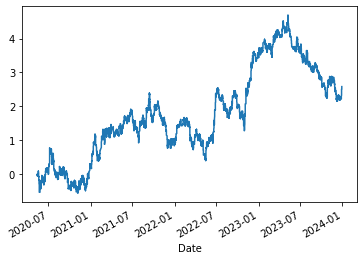

In [6]:
final_df['Return'].cumsum().plot()

# Assume 252 trading date in one year

# Sharpe Ratio
# One year HK Treasury Bill rate is around 4% --> let the risk free rate be 4%
Sharpe_Ratio=(final_df['Return'].mean()*252-0.04) / (final_df['Return'].std()*sqrt(252))
print(f"Sharpe Ratio = {Sharpe_Ratio}")

# Annual Return = (1 + Daily Return)^252 - 1
Annual_return=( (1+final_df['Return'].mean()) **252 )-1
print(f"Auual Return = {Annual_return:.1%}")

### ----------------------------------------------------------------------------------------------------------------------------------

## For 503 stocks in the S&P500 

In [7]:
select_df=pd.DataFrame()

for stock in tqdm(SPX_stocks_list):
    
    try:
        
        # Get data from yahoo finance
        df=yf.download(stock, start="2020-01-01", end="2024-01-01")
        
        # State the stock symbol
        df["Stock"]=stock
        
        # Calculate Standard deviation by using the daily close-to-close returns of the last 90 days
        df["Std"]=df["Close"].rolling(90).std()
        
        # Create a new column for copying the previous day's low
        df["Previous_Low"]=df["Low"].shift(1)
        
        # Condition 1: (Previous day's Low - Today's open) < 1 Standard deviation
        df["Condition_1"]= (df["Previous_Low"]-df["Open"]) < df["Std"]
        
        # Find 20-day_moving_average by using closing prices
        df["20-day_moving_average"]=df["Close"].rolling(20).mean()
        # Condition 2: Open Prices > 20-day_moving_average
        df["Condition_2"]= (df["Open"]>df["20-day_moving_average"])
        
        # Filter out the data which fulfil both condition 1 and condition 2
        df["Filter"]=df["Condition_1"] & df["Condition_2"]

        # Calculate return
        df1=df[df["Filter"]==True].copy()
        # Set stop loss of 3%
        df1["Return"]=(df["Close"]-df["Open"])/df["Open"]
        df1["Return"]=df1["Return"].apply(lambda x: max(x, -0.03))

        # Store the filter data in select_df
        select_df=pd.concat([select_df, df1])
        select_df=select_df.sort_index(ascending=True)
        
    except:
        
        pass
    

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [8]:
final_df=pd.DataFrame()

# For each unique data in select_df, we will only buy the 10 stocks that have the 
# lowest return from their previous day's lows.
for date in tqdm(np.unique(select_df.index)):
    try:
        # Select all the data within one specific date
        Stocks_10=select_df.loc[date]
        
        # Sort by their previous day's lows
        Stocks_10=Stocks_10.sort_values(by="Previous_Low", ascending=True)
        
        # Select only first 10 of stock. 
        # If the list has fewer than 10 stocks, then buy the entire list.
        Stocks_10=Stocks_10[:min(10, Stocks_10.shape[0])]
        
        # Store the final selected data in final_df
        final_df=pd.concat([final_df, Stocks_10])
    
    except:
        pass
    
final_df.head(50)

100%|██████████| 917/917 [00:00<00:00, 1056.84it/s]


,Open,High,Low,Close,Adj Close,Volume,Stock,Std,Previous_Low,Condition_1,20-day_moving_average,Condition_2,Filter,Return
Date,,,,,,,,,,,,,,
2020-05-11,5.180000,5.190000,5.050000,5.120000,4.229358,75734000.0,F,1.835561,4.950000,True,5.020500,True,True,-0.011583
2020-05-11,5.700000,5.840000,5.610000,5.750000,5.407229,29104500.0,MRO,3.808657,5.520000,True,5.038000,True,True,0.008772
2020-05-11,7.807500,8.112500,7.778750,8.065500,8.037873,469060000.0,NVDA,0.652831,7.659750,True,7.316112,True,True,0.033045
2020-05-11,8.510000,8.600000,8.180000,8.230000,6.698185,7664800.0,HBAN,2.882576,8.430000,True,8.350000,True,True,-0.030000
2020-05-11,8.750000,8.930000,8.560000,8.830000,7.241390,5269700.0,AMCR,1.306094,8.740000,True,8.678500,True,True,0.009143
2020-05-11,8.950000,9.050000,8.850000,8.980000,8.558970,16171500.0,FCX,2.399313,9.110000,True,8.442000,True,True,0.003352
2020-05-11,9.700889,9.765562,9.086500,9.320938,8.750305,9273294.0,BBWI,4.238129,9.223929,True,9.651172,True,True,-0.030000
2020-05-11,10.080000,10.122000,9.660000,9.730000,8.452274,7776300.0,HPE,2.611153,9.710000,True,9.608000,True,True,-0.030000
2020-05-11,10.140000,10.140000,9.660000,9.810000,8.160180,10962000.0,RF,3.308797,10.010000,True,9.874000,True,True,-0.030000


Sharpe Ratio = 0.7024669767946651
Auual Return = 31.6%


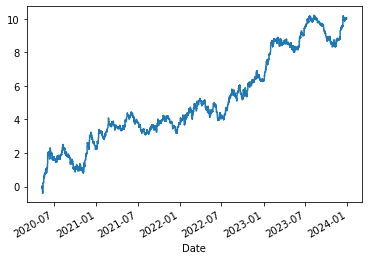

In [9]:
final_df['Return'].cumsum().plot()

# Assume 252 trading date in one year

# Sharpe Ratio
# One year US Treasury Bill rate is around 5% --> let the risk free rate be 5%
Sharpe_Ratio=(final_df['Return'].mean()*252-0.05) / (final_df['Return'].std()*sqrt(252))
print(f"Sharpe Ratio = {Sharpe_Ratio}")

# Annual Return = (1 + Daily Return)^252 - 1
Annual_return=( (1+final_df['Return'].mean()) **252 )-1
print(f"Auual Return = {Annual_return:.1%}")

## Further Studies:

1. This model only buys stocks within the list of ETF, but we can also short the stocks


2. Other factors to consider when deciding which stock to buy:
   - method to calculate standard deviation
   - method to observe moving average
   
   
3. This model forms a portfolio of equal capital on each stock. In reality, how to determine the weight of each stock? (linear regression / Johansen test / Constrained optimization)



4. How to determine the stop loss and take profit ratio?
